In [1]:
#export
import torch
import torch.nn as nn
from fastai.vision.all import *
import time
from IPython.display import display, clear_output
from fastai.data.all import *
import pandas as pd
from pathlib import Path
import regex as re
import numpy as np
from collections.abc import Sequence


In [2]:
#export
def show_frames(video,start=0, end=5):
    '''show frames in a video from start to end'''
    for frame in video[start:end]:
        clear_output(wait=True)
        frame.show()
        time.sleep(0.5)


In [32]:

@patch 
def insert(l:L, i, o):
    l.items.insert(i, o)

class Video(L):
    ''' the init function takes a list of PILImage s'''  

    @classmethod
    def create(cls, paths:(L,list,str), sep='\n'): 
        '''create images from frames path in a video'''
        paths = paths.split(sep) if isinstance(paths, str) else paths
        return cls(map(PILImage.create, paths))
    
    def __mul__(self, n):
        neg = n < 0
        if n==0 or abs(n) >=1: return self[[(i+neg)//n for i in range(abs(int(n))*len(self))]]
        else: return self/(1/n)
        
    def __truediv__(self, n):
        n = int(n)
        return self[::n]
    
    def __rmul__(self, n):
        return self*n
    
    def __getitem__(self, idx): return self._get(idx) if is_indexer(idx) else Video(self._get(idx), use_list=None, ID=self.ID)      


In [31]:
Video.create(['../videodata/Charades_v1_rgb/NWFOF/NWFOF-000476.jpg','../videodata/Charades_v1_rgb/NWFOF/NWFOF-000477.jpg']).ID

'../videodata/Charades_v1_rgb/NWFOF/NWFOF-000476.jpg'

In [33]:
#export

@patch 
def insert(l:L, i, o):
    l.items.insert(i, o)
#Video class with ID 
class Video(L):
    ''' the init function takes a list of PILImage s'''  
    def __init__(self, items=None, *rest, use_list=False, match=None, ID=None):
        self.ID=ID
        L.__init__(self, items=items, *rest, use_list=use_list, match=match)
    @classmethod
    def create(cls, paths:(L,list,str), sep='\n'): 
        '''create images from frames path in a video'''
        paths = paths.split(sep) if isinstance(paths, str) else paths
        return cls(map(PILImage.create, paths),ID=paths[0])
    
    def __mul__(self, n):
        neg = n < 0
        if n==0 or abs(n) >=1: return self[[(i+neg)//n for i in range(abs(int(n))*len(self))]]
        else: return self/(1/n)
        
    def __truediv__(self, n):
        n = int(n)
        return self[::n]
    
    def __rmul__(self, n):
        return self*n
    
    def __getitem__(self, idx): return self._get(idx) if is_indexer(idx) else Video(self._get(idx), use_list=None, ID=self.ID)      


In [107]:
#export
def snippets_from_video(vid, l=10, s=2):
    '''create list of snippet out a video'''
    vid=vid[::s] # skip frames
    return [Video([vid[i] for i in range(k*l, k*l + l)]) for k in range(0,len(vid)//l)]
        
def stretch(vid, l):
    vid = vid*(l//len(vid))
    if len(vid) == l: return vid
    lv = len(vid)
    n = l - lv                     # Number of frames to be inserted
    d = lv//n                      # Number of frames between inserted frames
    idxs = L(range(lv))
    for i in range(n):
        idxs.insert((d+1)*i, d*i)
    return vid[idxs]

class ResizeTime(Transform):
    split_idx = None # 0- train 1- validation 
    def __init__(self, skip=2, l=50, drop_last=True,**kwargs): 
        self.skip = skip
        self.l = l
        self.drop_last = drop_last
        super().__init__(**kwargs)
        
    def encodes(self, vid:Video, split_idx=split_idx):
        '''create a list of frame-images (snippet) out a single video path'''
        l, skip, l_vid = self.l, self.skip, len(vid)
        if l_vid > l*skip:
            snippet_list = snippets_from_video(vid,s=skip,l=l)
            idx = len(snippet_list)//2 if split_idx else random.randint(0,len(snippet_list)-1) # ** if validation always takes middle snip
            return snippet_list[idx]     
        else:
            vid = vid[::skip]
            vid = stretch(vid, l)         
        return vid
 

In [116]:
#export
@ToTensor
def encodes(self, vid:Video):
    return vid.stack().float().permute(3,0,1,2)


In [117]:
path_charades = Path('/mnt/data/adrianlopez/Videos/Charades') 
vid = pd.read_csv(path_charades/'df0.csv', index_col=0).loc[0]
vid = ResizeTime(50)(Video.create(DF2Paths(path_charades)(vid)))
vid


(#50) [PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180...]

In [118]:
ToTensor()(vid).shape

torch.Size([3, 50, 180, 320])

In [87]:
#export
def _get_sz(x):
    if isinstance(x, tuple): x = x[0]
    if not isinstance(x, Tensor): return fastuple(x.size)
    return fastuple(x.get_meta('img_size', x.get_meta('sz', (x.shape[-1], x.shape[-2]))))

@Resize
def encodes(self, video:Video):
        nw_vid=[]
        for frame in video:
            orig_sz = _get_sz(frame)
            w,h = orig_sz
            op = (operator.lt,operator.gt)[self.method==ResizeMethod.Pad]
            m = w/self.size[0] if op(w/self.size[0],h/self.size[1]) else h/self.size[1]
            cp_sz = (int(m*self.size[0]),int(m*self.size[1]))
            tl = fastuple(int(self.pcts[0]*(w-cp_sz[0])), int(self.pcts[1]*(h-cp_sz[1])))
            fastaiImg = PILImage.create(np.array(frame.crop_pad(cp_sz, tl, orig_sz=orig_sz, pad_mode=self.pad_mode,
                       resize_mode=self.mode_mask if isinstance(frame,PILMask) else self.mode, resize_to=self.size)))
            nw_vid.append(fastaiImg)
        return Video(nw_vid)


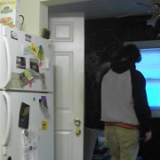

In [94]:
path_charades = Path('/mnt/data/adrianlopez/Videos/Charades') 
vid = pd.read_csv(path_charades/'df0.csv', index_col=0).loc[0]
vid = Video.create(DF2Paths(path_charades)(vid))
Resize(160)(vid)[0]

In [6]:
#export
def uniformize_dataset(lbls, n_el=3, n_lbl=3, shuffle=True):
    vocab = list(set(lbls))
    lbl2idxs = {lbl:[] for lbl in vocab}
    for i, lbl in enumerate(lbls): lbl2idxs[lbl].append(i)
    if shuffle: [random.shuffle(v) for v in lbl2idxs.values()]
    idxs = []
    while len(vocab) >= n_lbl:
        lbl_samples = random.sample(vocab, n_lbl)
        for lbl in lbl_samples:
            for i in range(n_el):
                idx = lbl2idxs[lbl].pop()
                idxs.append(idx)
            if len(lbl2idxs[lbl]) <= n_el:
                vocab.remove(lbl)
    return idxs

In [22]:
path_charades = Path('/mnt/data/adrianlopez/Videos/Charades') 
items = pd.read_csv(path_charades/'df0.csv', index_col=0)
items = items.iloc[uniformize_dataset(items['lbl'])]
items.tail(6)

,id,coded_lbl,lbl,start,end,test
27930,Y5ZU3,c154,Someone is standing up from somewhere,13.3,19.8,False
66309,W8XQ9,c154,Someone is standing up from somewhere,0.8,28.7,True
18355,DJ7DG,c154,Someone is standing up from somewhere,11.7,18.0,False
56432,DPB7X,c059,Sitting in a chair,0.0,10.0,True
30925,RF00I,c059,Sitting in a chair,16.9,43.3,False
2003,X42YA,c059,Sitting in a chair,14.3,32.3,False


In [7]:
#export
class UniformizedShuffle():
    def __init__(self, lbls, n_el=3, n_lbl=3):
        self.lbls = lbls
        self.n_el = n_el
        self.n_lbl = n_lbl
    def __call__ (self, x=None):
        return uniformize_dataset(lbls=self.lbls, n_el=self.n_el, n_lbl=self.n_lbl)
   

In [8]:
path_charades = Path('/mnt/data/eugeniomarinelli/videodata') 
items = pd.read_csv(path_charades/'df.csv', index_col=0)
un = UniformizedShuffle(items['lbl'])
idxs = un()
items.iloc[idxs].tail(6)

,id,coded_lbl,lbl,start,end,val,paths
35697,NWFOF,c097,Walking through a doorway,19.8,26.6,False,videodata/Charades_v1_rgb/NWFOF/NWFOF-000476.jpg\nvideodata/Charades_v1_rgb/NWFOF/NWFOF-000477.jpg\nvideodata/Charades_v1_rgb/NWFOF/NWFOF-000478.jpg\nvideodata/Charades_v1_rgb/NWFOF/NWFOF-000479.jpg\nvideodata/Charades_v1_rgb/NWFOF/NWFOF-000480.jpg\nvideodata/Charades_v1_rgb/NWFOF/NWFOF-000481.jpg\nvideodata/Charades_v1_rgb/NWFOF/NWFOF-000482.jpg\nvideodata/Charades_v1_rgb/NWFOF/NWFOF-000483.jpg\nvideodata/Charades_v1_rgb/NWFOF/NWFOF-000484.jpg\nvideodata/Charades_v1_rgb/NWFOF/NWFOF-000485.jpg\nvideodata/Charades_v1_rgb/NWFOF/NWFOF-000486.jpg\nvideodata/Charades_v1_rgb/NWFOF/NWFOF-000487.j...
62371,Q7TXX,c097,Walking through a doorway,0.0,3.4,True,videodata/Charades_v1_rgb/Q7TXX/Q7TXX-000001.jpg\nvideodata/Charades_v1_rgb/Q7TXX/Q7TXX-000002.jpg\nvideodata/Charades_v1_rgb/Q7TXX/Q7TXX-000003.jpg\nvideodata/Charades_v1_rgb/Q7TXX/Q7TXX-000004.jpg\nvideodata/Charades_v1_rgb/Q7TXX/Q7TXX-000005.jpg\nvideodata/Charades_v1_rgb/Q7TXX/Q7TXX-000006.jpg\nvideodata/Charades_v1_rgb/Q7TXX/Q7TXX-000007.jpg\nvideodata/Charades_v1_rgb/Q7TXX/Q7TXX-000008.jpg\nvideodata/Charades_v1_rgb/Q7TXX/Q7TXX-000009.jpg\nvideodata/Charades_v1_rgb/Q7TXX/Q7TXX-000010.jpg\nvideodata/Charades_v1_rgb/Q7TXX/Q7TXX-000011.jpg\nvideodata/Charades_v1_rgb/Q7TXX/Q7TXX-000012.j...
37837,R8OTI,c097,Walking through a doorway,0.0,6.3,False,videodata/Charades_v1_rgb/R8OTI/R8OTI-000001.jpg\nvideodata/Charades_v1_rgb/R8OTI/R8OTI-000002.jpg\nvideodata/Charades_v1_rgb/R8OTI/R8OTI-000003.jpg\nvideodata/Charades_v1_rgb/R8OTI/R8OTI-000004.jpg\nvideodata/Charades_v1_rgb/R8OTI/R8OTI-000005.jpg\nvideodata/Charades_v1_rgb/R8OTI/R8OTI-000006.jpg\nvideodata/Charades_v1_rgb/R8OTI/R8OTI-000007.jpg\nvideodata/Charades_v1_rgb/R8OTI/R8OTI-000008.jpg\nvideodata/Charades_v1_rgb/R8OTI/R8OTI-000009.jpg\nvideodata/Charades_v1_rgb/R8OTI/R8OTI-000010.jpg\nvideodata/Charades_v1_rgb/R8OTI/R8OTI-000011.jpg\nvideodata/Charades_v1_rgb/R8OTI/R8OTI-000012.j...
11887,YV874,c059,Sitting in a chair,14.2,31.0,False,videodata/Charades_v1_rgb/YV874/YV874-000341.jpg\nvideodata/Charades_v1_rgb/YV874/YV874-000342.jpg\nvideodata/Charades_v1_rgb/YV874/YV874-000343.jpg\nvideodata/Charades_v1_rgb/YV874/YV874-000344.jpg\nvideodata/Charades_v1_rgb/YV874/YV874-000345.jpg\nvideodata/Charades_v1_rgb/YV874/YV874-000346.jpg\nvideodata/Charades_v1_rgb/YV874/YV874-000347.jpg\nvideodata/Charades_v1_rgb/YV874/YV874-000348.jpg\nvideodata/Charades_v1_rgb/YV874/YV874-000349.jpg\nvideodata/Charades_v1_rgb/YV874/YV874-000350.jpg\nvideodata/Charades_v1_rgb/YV874/YV874-000351.jpg\nvideodata/Charades_v1_rgb/YV874/YV874-000352.j...
45152,NKTWF,c059,Sitting in a chair,5.7,11.4,False,videodata/Charades_v1_rgb/NKTWF/NKTWF-000137.jpg\nvideodata/Charades_v1_rgb/NKTWF/NKTWF-000138.jpg\nvideodata/Charades_v1_rgb/NKTWF/NKTWF-000139.jpg\nvideodata/Charades_v1_rgb/NKTWF/NKTWF-000140.jpg\nvideodata/Charades_v1_rgb/NKTWF/NKTWF-000141.jpg\nvideodata/Charades_v1_rgb/NKTWF/NKTWF-000142.jpg\nvideodata/Charades_v1_rgb/NKTWF/NKTWF-000143.jpg\nvideodata/Charades_v1_rgb/NKTWF/NKTWF-000144.jpg\nvideodata/Charades_v1_rgb/NKTWF/NKTWF-000145.jpg\nvideodata/Charades_v1_rgb/NKTWF/NKTWF-000146.jpg\nvideodata/Charades_v1_rgb/NKTWF/NKTWF-000147.jpg\nvideodata/Charades_v1_rgb/NKTWF/NKTWF-000148.j...
39845,IYU90,c059,Sitting in a chair,0.0,32.0,False,videodata/Charades_v1_rgb/IYU90/IYU90-000001.jpg\nvideodata/Charades_v1_rgb/IYU90/IYU90-000002.jpg\nvideodata/Charades_v1_rgb/IYU90/IYU90-000003.jpg\nvideodata/Charades_v1_rgb/IYU90/IYU90-000004.jpg\nvideodata/Charades_v1_rgb/IYU90/IYU90-000005.jpg\nvideodata/Charades_v1_rgb/IYU90/IYU90-000006.jpg\nvideodata/Charades_v1_rgb/IYU90/IYU90-000007.jpg\nvideodata/Charades_v1_rgb/IYU90/IYU90-000008.jpg\nvideodata/Charades_v1_rgb/IYU90/IYU90-000009.jpg\nvideodata/Charades_v1_rgb/IYU90/IYU90-000010.jpg\nvideodata/Charades_v1_rgb/IYU90/IYU90-000011.jpg\nvideodata/Charades_v1_rgb/IYU90/IYU90-000012.j...


In [ ]:
def get_snippets(path_to_csv, col_name='paths', skip=3, l=25, sep='\n'):
        '''create a list of all snippets in path form'''
        df=pd.read_csv(path_to_csv)
        vds=[v.split(sep) for v in df[col_name]] #  list of frames in a list of all the videos
        ll_snip=[snippets_from_video(el,l,skip) for el in vds] # list of videos cont list of snips cont list of frames 
        return [s for l_snip in ll_snip for s in l_snip] #flatten list

In [34]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_triplet_loss.ipynb.
Converted 02_inflator.ipynb.
Converted 03_video_block.ipynb.
Converted 04_datasets.ipynb.
Converted TrainigVideoClassifier.ipynb.
Converted index.ipynb.


In [5]:
# default_exp video_block